## Protein-coding genes on autosomes, with annotations
Annotate all genes from HGNC map with: 
- coding sequence info
- paralog info (incl. seq id and duplication mode)
- essentiality info
- cancer driver info

In [5]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import os
import warnings
warnings.simplefilter("ignore")
from matplotlib_venn import venn2, venn3, venn3_circles
import matplotlib.pyplot as plt
import re
import seaborn as sns

import processing_utils as util
%load_ext autoreload
%autoreload 1
%aimport processing_utils

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)
get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)


file_gene_id_map = get_data_path(['HGNC'], 'hgnc_complete_set_2021-07-01.txt')

file_paralog_genes = get_local_data_path(['processed','ensembl_93'], 'all_paralog_genes_min20.csv')
file_ccds = get_data_path(['ccds_gene_annotations'], 'hg19.txt')
file_ascat_segment_bounds = get_local_data_path(['processed','TCGA','ASCAT'], 'segment_boundaries.csv')

# Essentiality
file_depmap_gene_scores = get_data_path(['depmap','20Q2'], 'gene_scores_16_04_21.csv')
file_bassik_3d_crispr = get_data_path(['han_2020_3d_crispr'], 'TableS1.xlsx')
file_blomen = lambda n: get_data_path(['blomen_2015'], 'aac7557_sm_table_s'+str(n)+'.xlsx') # gene trap method

# Drivers
file_cosmic_drivers = get_data_path(['COSMIC','v95'], 'Census_allWed Feb 23 22_04_39 2022.tsv') # hg38
file_bailey_drivers = get_data_path(['TCGA'], 'Bailey_2018_supplemental_tables.xlsx') # Table S1

# OUTPUT
file_gene_annot = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Symbols + IDs

In [6]:
# All protein-coding genes
gene_id_map = pd.read_csv(file_gene_id_map, sep='\t')[['symbol','entrez_id','ensembl_gene_id','locus_type']]
gene_id_map = gene_id_map[gene_id_map.locus_type=='gene with protein product'].drop(columns=['locus_type'])\
                         .dropna(subset=['entrez_id','ensembl_gene_id']).astype({'entrez_id':'int'})\
                         .rename(columns={'ensembl_gene_id':'ensembl_id'}).reset_index(drop=True)
print('N genes:', gene_id_map.symbol.nunique())
gene_id_map[:1]

N genes: 19167


,symbol,entrez_id,ensembl_id
0,A1BG,1,ENSG00000121410


### CCDS

In [7]:
ccds_all = util.load_ccds(file_ccds)
ccds_all['ccds_id'] = ccds_all['ccds_id'].apply(lambda x: x.split('.')[0])
ccds = ccds_all[(ccds_all.entrez_id.isin(gene_id_map.entrez_id))].reset_index(drop=True)
print('N:', ccds.shape[0])
display(ccds[:1])

N: 18393


,chr,entrez_id,cds_from,cds_to,ccds_id,cds_len
0,1,79501,69090,70007,CCDS30547,917


### Gene essentiality
#### 1. DepMap

In [8]:
ceres_scores = pd.read_csv(file_depmap_gene_scores, index_col=0)

In [9]:
depmap = ceres_scores.apply(lambda x: sum(x<-0.6)/ceres_scores.shape[0]*100)
depmap = depmap.reset_index(name='pct').rename(columns={'index':'entrez_id'})
depmap['depmap_ess_cat'] = depmap.pct.apply(lambda x: 'broadly' if x >90 else 'never' if x==0 else 'sometimes')
depmap['depmap_ess'] = depmap['depmap_ess_cat'] == 'broadly'

In [10]:
print('N DepMap 20Q2 broadly essential:', sum(depmap.depmap_ess), '/', depmap.shape[0])
depmap[:1]

N DepMap 20Q2 broadly essential: 972 / 16438


,entrez_id,pct,depmap_ess_cat,depmap_ess
0,1,0.0,never,False


#### 2. Bassik lab 3D CRISPR
Note: different gene ids for same ensembl id!

In [11]:
bassik_h23_3d = pd.read_excel(file_bassik_3d_crispr, engine='openpyxl', sheet_name='H23 3D Genome-wide data')

In [12]:
bassik_h1975_3d = pd.read_excel(file_bassik_3d_crispr, engine='openpyxl', sheet_name='H1975 3D Genome-wide data')

In [13]:
bassik_h2009_3d = pd.read_excel(file_bassik_3d_crispr, engine='openpyxl', sheet_name='H2009 3D Genome-wide data')

In [14]:
print('N genes per cell lines:', bassik_h23_3d.shape[0], bassik_h1975_3d.shape[0], bassik_h2009_3d.shape[0])

N genes per cell lines: 19970 19996 19988


In [15]:
print('N genes w/ significant negative growth phenotype (10% FDR):', 
      bassik_h23_3d[(bassik_h23_3d['MWU Q-val']<0.1) & (bassik_h23_3d.Tscore<0)].shape[0], 
      bassik_h1975_3d[(bassik_h1975_3d['MWU Q-val']<0.1) & (bassik_h1975_3d.Tscore<0)].shape[0],
      bassik_h2009_3d[(bassik_h2009_3d['MWU Q-val']<0.1) & (bassik_h2009_3d.Tscore<0)].shape[0])

N genes w/ significant negative growth phenotype (10% FDR): 6041 5427 3971


In [16]:
# Genes that are in top 2000 signfic hits in the 3 cell lines
topn=2000
f = lambda x: (x['MWU Q-val']<0.1) & (x.Tscore<0)
top_3d_hits = pd.concat([bassik_h23_3d[bassik_h23_3d.apply(f, axis=1)].sort_values('Tscore')[:topn], 
                         bassik_h1975_3d[bassik_h1975_3d.apply(f, axis=1)].sort_values('Tscore')[:topn],
                         bassik_h2009_3d[bassik_h2009_3d.apply(f, axis=1)].sort_values('Tscore')[:topn]])
top_3d_hits = top_3d_hits.groupby(['EnsemblID','Symbol']).size().reset_index(name='n_cell_lines')
print('Top 2000 hits from each cell line - overlap:', top_3d_hits[top_3d_hits.n_cell_lines>=2].shape[0])

Top 2000 hits from each cell line - overlap: 1576


In [17]:
bassik_3d = pd.merge(bassik_h23_3d[['EnsemblID','Symbol']], bassik_h1975_3d[['EnsemblID','Symbol']])
bassik_3d = pd.merge(bassik_3d, bassik_h2009_3d[['EnsemblID','Symbol']])
bassik_3d = pd.merge(bassik_3d, top_3d_hits, how='left').fillna({'n_cell_lines':0})
bassik_3d = pd.merge(bassik_3d.rename(columns={'EnsemblID':'ensembl_id', 'Symbol':'symbol'}), gene_id_map[['ensembl_id']])
bassik_3d['essential'] = bassik_3d.n_cell_lines>=2
print('Top hits:', sum(bassik_3d.essential))
bassik_3d[:1]

Top hits: 1469


,ensembl_id,symbol,n_cell_lines,essential
0,ENSG00000117450,PRDX1,3.0,True


#### 3. Blomen gene trap

In [18]:
blomen_kbm7 = pd.read_excel(file_blomen(1), engine='openpyxl', skiprows=1)
blomen_hap1 = pd.read_excel(file_blomen(2), engine='openpyxl', skiprows=1)

In [19]:
# Identify genes essential (selected) and not essential in both cell lines (p > 0.05)
blomen_gt = pd.merge(blomen_kbm7, blomen_hap1, on=['ENSEMBL_ID']).rename(columns={'ENSEMBL_ID':'ensembl_id'})
blomen_gt = blomen_gt[['ensembl_id']].assign(essential = (blomen_gt.selected_x=='YES') & (blomen_gt.selected_y=='YES'))
# Merge with my gene IDs
blomen = pd.merge(blomen_gt, gene_id_map[['ensembl_id']])
print('N. Blomen gene trap essential:', sum(blomen.essential))
blomen[:1]

N. Blomen gene trap essential: 1718


,ensembl_id,essential
0,ENSG00000127837,True


### Paralogs

In [20]:
paralogs = pd.read_csv(file_paralog_genes).drop(columns=['entrez_id'])
print('N:', paralogs.shape[0])
paralogs[:1]

N: 12128


,symbol,n_paralogs,WGD,max_seq_id
0,A1CF,4,True,46.8439


### Driver genes
#### 1. Cancer Gene Census

In [21]:
cgc = pd.read_csv(file_cosmic_drivers, sep='\t')
cgc = cgc[['Gene Symbol','Entrez GeneId','Role in Cancer','Mutation Types','Genome Location']]
cgc['TSG'] = cgc['Role in Cancer'].apply(lambda x: 'TSG' in x if not pd.isna(x) else True)
cgc['OG'] = cgc['Role in Cancer'].apply(lambda x: 'oncogene' in x if not pd.isna(x) else True)
print('N cosmic TSGs:', sum(cgc.TSG))

N cosmic TSGs: 349


In [22]:
# Missing IDs - not included
display(cgc[~cgc['Entrez GeneId'].isin(gene_id_map.entrez_id)])
display(cgc[~cgc['Entrez GeneId'].isin(gene_id_map.entrez_id) & cgc['Gene Symbol'].isin(gene_id_map.symbol)])

,Gene Symbol,Entrez GeneId,Role in Cancer,Mutation Types,Genome Location,TSG,OG
188,DUX4L1,NaN,fusion,T,4:190084412-190085686,False,False
193,EIF1AX,107984923.0,NaN,"Mis, S",X:20124518-20141844,True,True
301,HMGN2P46,NaN,fusion,T,15:45511136-45556730,False,False
319,IGH,3492.0,fusion,T,14:-,False,False
320,IGK,50802.0,fusion,T,2:-,False,False
321,IGL,3535.0,fusion,T,22:-,False,False
385,MALAT1,NaN,"oncogene, TSG, fusion",T,11:65497762-65506469,True,True
398,MDS2,NaN,fusion,T,1:23581495-23640568,False,False
684,TRA,6955.0,fusion,T,14:-,False,False
686,TRB,6957.0,fusion,T,7:-,False,False


,Gene Symbol,Entrez GeneId,Role in Cancer,Mutation Types,Genome Location,TSG,OG
193,EIF1AX,107984923.0,NaN,"Mis, S",X:20124518-20141844,True,True


#### 2. Bailey et al - based on MC3 somatic mutation calls

In [23]:
bailey = pd.read_excel(file_bailey_drivers, sheet_name='Table S1',engine='openpyxl',skiprows=3).dropna(subset=['Gene'])
bailey = bailey.rename(columns={'Tumor suppressor or oncogene prediction (by 20/20+)':'role'})

# MANUAL CURATION OF NEW SYMBOLS
display(bailey[~bailey.Gene.isin(gene_id_map.symbol)])
bailey = bailey.replace({'FAM46D':'TENT5D', 'H3F3A':'H3-3A', 'H3F3C':'H3-5', 'HIST1H1C':'H1-2', 'HIST1H1E':'H1-4',
                         'RQCD1':'CNOT9', 'TCEB1':'ELOC', 'WHSC1':'NSD2'})

bailey['TSG'] = bailey['role'].isin(['tsg','possible tsg']) | bailey['role'].isna()
bailey['OG'] = bailey['role'].isin(['oncogene','possible oncogene']) | bailey['role'].isna()
print('N Bailey TSGs:', bailey[bailey.TSG].Gene.nunique())
print('N Bailey et al. OGs:', bailey[bailey.OG].Gene.nunique())

,Gene,Cancer,KEY,role,Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
229,FAM46D,STAD,FAM46D_STAD,oncogene,official,0.019608,0.011014,1.0,0.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,H3F3A,PANCAN,H3F3A_PANCAN,possible oncogene,official,NaN,0.003414,1.5,1.500000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,H3F3C,PANCAN,H3F3C_PANCAN,NaN,official,NaN,0.007049,0.5,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,HIST1H1C,PANCAN,HIST1H1C_PANCAN,NaN,rescued,NaN,0.011345,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,HIST1H1E,DLBC,HIST1H1E_DLBC,possible oncogene,official,0.270270,0.010794,2.0,1.195172,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,HIST1H1E,LIHC,HIST1H1E_LIHC,possible tsg,official,0.014124,0.010794,2.0,1.456097,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,RQCD1,PANCAN,RQCD1_PANCAN,possible oncogene,official,NaN,0.003745,1.5,1.500000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,RQCD1,SKCM,RQCD1_SKCM,oncogene,official,0.030806,0.003745,3.0,3.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,TCEB1,KIRC,TCEB1_KIRC,possible tsg,official,0.010870,0.001872,1.5,1.500000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
721,WHSC1,LIHC,WHSC1_LIHC,oncogene,official,0.025424,0.015640,1.5,1.500000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


N Bailey TSGs: 202
N Bailey et al. OGs: 156


### Merge into one gene annotations table

In [24]:
genes = pd.merge(gene_id_map, ccds) # Don't consider genes not in CCDS - will never map to these
genes['cds_mid'] = genes.apply(lambda x: x.cds_from+(x.cds_len*0.5), axis=1)
genes = genes[~genes['chr'].isin(['X','Y'])].astype({'chr':int}) # Only include autosome genes
print('N:', genes.shape[0])

# Add paralog info
genes = pd.merge(genes, paralogs, how='left', indicator='paralog')
genes['paralog'] = genes.paralog=='both'

# --- ESSENTIALITY ---
# From DepMap 20Q2 (my analysis)
genes = pd.merge(genes, depmap.astype({'entrez_id':int})[['entrez_id','depmap_ess','depmap_ess_cat']], how='left')

# From Blomen gene trap screen
genes = pd.merge(genes, blomen.rename(columns={'essential':'ess_gt'}), how='left')

# From 3D CRISPR
genes = pd.merge(genes, bassik_3d[['ensembl_id','essential']].rename(columns={'essential':'ess_3D'}), how='left')

# Add TSG + OG annotations
genes['TSG_CGC'] = genes.entrez_id.isin(cgc[cgc.TSG]['Entrez GeneId'])
genes['TSG_Bailey'] = genes.symbol.isin(bailey[bailey.TSG]['Gene'])
genes['TSG'] =  genes['TSG_CGC'] | genes['TSG_Bailey']
genes['OG'] = genes.entrez_id.isin(cgc[cgc.OG]['Entrez GeneId']) | genes.symbol.isin(bailey[bailey.OG]['Gene'])

print('TSGs:', sum(genes.TSG))
print('OGs:', sum(genes.OG))
print('Drivers:', sum(genes.OG | genes.TSG))
#print('Passengers in driver pair:', sum(~genes.OG & ~genes.TSG & genes.in_driver_pair))
print('Paralogs: %.2f%%' % (sum(genes.paralog)/genes.shape[0]*100))
print('WGDs: %.2f%% -- %.2f%%' % (sum(genes.WGD==True)/sum(genes.paralog)*100, sum(genes.WGD==True)/genes.shape[0]*100))
print('Sets of essential genes:', sum(genes.depmap_ess==True), sum(genes.ess_gt==True), sum(genes.ess_3D==True))
display(genes[:1])

N: 17572
TSGs: 411
OGs: 391
Drivers: 652
Paralogs: 63.08%
WGDs: 59.44% -- 37.49%
Sets of essential genes: 969 1664 1429


,symbol,entrez_id,ensembl_id,chr,cds_from,cds_to,ccds_id,cds_len,cds_mid,n_paralogs,...,max_seq_id,paralog,depmap_ess,depmap_ess_cat,ess_gt,ess_3D,TSG_CGC,TSG_Bailey,TSG,OG
0,A1BG,1,ENSG00000121410,19,58858387,58864802,CCDS12976,6415,58861594.5,NaN,...,NaN,False,False,never,False,False,False,False,False,False


In [25]:
print('TSGs that are paralogs: %.2f%%' % (sum(genes.paralog & genes.TSG)/sum(genes.TSG)*100))
ctab = pd.crosstab(genes.paralog, genes.TSG)
print('FET OR=%.2f, p=%.4f' % stats.fisher_exact(ctab))

TSGs that are paralogs: 69.10%
FET OR=1.32, p=0.0112


In [26]:
print('OGs that are paralogs: %.2f%%' % (sum(genes.paralog & genes.OG)/sum(genes.OG)*100))
ctab = pd.crosstab(genes.paralog, genes.OG)
print('FET OR=%.2f, p=%.4e' % stats.fisher_exact(ctab))

OGs that are paralogs: 82.61%
FET OR=2.83, p=1.8119e-17


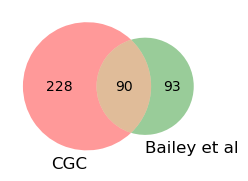

In [27]:
f, ax = plt.subplots(1, 1, figsize=(3,2))
v = venn2([set(genes[genes.TSG_CGC].symbol.values), set(genes[genes.TSG_Bailey].symbol.values)], ('CGC', 'Bailey et al'))

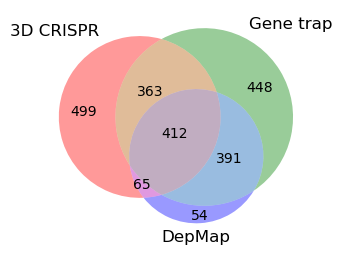

In [28]:
f, ax = plt.subplots(1, 1, figsize=(3.5,3.5))
df = genes.dropna(subset=['depmap_ess','ess_3D','ess_gt'])
v = venn3([set(df[df.ess_3D].symbol.values), set(df[df.ess_gt].symbol.values), set(df[df.depmap_ess].symbol.values)],
          ('3D CRISPR', 'Gene trap', 'DepMap'))

#### Genes fully within coding region of a TSG

In [29]:
# Identify any genes overlapping each freq del TSG
genes_within_drivers = pd.DataFrame()
for row in genes[genes.TSG | genes.OG].iterrows():
    df = genes[(genes.symbol != row[1].symbol) & (genes.chr == row[1].chr) & 
               (((genes.cds_from >= row[1].cds_from) & (genes.cds_from <= row[1].cds_to)) |
                ((genes.cds_to >= row[1].cds_from) & (genes.cds_to <= row[1].cds_to)))][['symbol','paralog']]
    if df.shape[0]>0: genes_within_drivers = pd.concat([genes_within_drivers, df.assign(driver = row[1].symbol)])
print(genes_within_drivers.shape[0],'-',genes_within_drivers.symbol.unique())
genes['within_driver'] = genes.symbol.isin(genes_within_drivers.symbol)

16 - ['SDCCAG8' 'B3GALT2' 'LRRTM1' 'MBOAT4' 'FNTB' 'ANGPTL7' 'TOE1' 'MAB21L1'
 'EVI2A' 'EVI2B' 'OMG' 'INSRR' 'SH2D2A' 'FAM20A' 'LPAR6' 'LRRC4']


#### Genes outside of ASCAT bounds
These genes could never be counted as fully deleted in the TCGA data

In [30]:
seg_bounds = pd.read_csv(file_ascat_segment_bounds, index_col=0)
seg_bounds[:1]

,startpos,endpos,cent_start,cent_end
chr,,,,
1,61735,249224388,121482979.0,144007049.0


In [31]:
outside_bounds = pd.DataFrame()
for c in range(1,22):
    outside_bounds = pd.concat([outside_bounds, genes[(genes.chr==c) &  ((genes.cds_from < seg_bounds.loc[c].startpos) | 
                                                                         (genes.cds_to > seg_bounds.loc[c].endpos))]])
genes['outside_bounds'] = genes.symbol.isin(outside_bounds.symbol)
print(outside_bounds.shape[0],'-',outside_bounds.symbol.unique())

6 - ['OR4F3' 'ODF3' 'SCGB1C1' 'ANHX' 'ZNF268' 'METRNL']


In [32]:
genes.to_csv(file_gene_annot, index=0)